# REVIEW: analysis of the confidence interval of RMSE
---
The reviewer suggested to analyze the confidence interval of RMSE:
> 4. The results are clearly presented and effectively link grid–mesh geometry to forecast artifacts, offering a novel geometric interpretation of GNN behavior. The discussion provides useful operational insights, particularly regarding optimal connectivity and bathymetry-aware mesh design. However, the analysis relies heavily on visual evidence without statistical validation or quantitative metrics to confirm the significance of the reported RMSE improvements. The conclusions would be stronger with confidence intervals, replication across regions, or cost–benefit analysis of computational trade-offs. Overall, the discussion is insightful but would benefit from more rigorous quantitative support.

In [2]:
# Standard library imports
import re
import sys, os
import warnings
from enum import Enum
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')  # Colorblind-friendly style

# First-party imports
sys.path.append(os.path.expanduser('~/Seacast'))
from src.seacast_tools.scoring_analysis import *

# Third-party imports
import jax
from bayesnf.spatiotemporal import BayesianNeuralFieldVI
from sklearn.model_selection import train_test_split

# Set up session settings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
# Create a Enums for different types
class NNodes(Enum):
    def __init__(self, num, alias):
        self.num = num
        self.alias = alias

    N14_9 = ("14_9", "5_4")
    N20_9 = ("20_9", "6_4")
    N34_20 = ("34_20", "8_6")
    N52_27 = ("52_27", "10_7")
    N159_78 = ("159_78", "17_12")

    @classmethod
    def get(cls, key):
        for member in cls:
            if key in (member.num, member.alias, member.name):
                return member
        raise ValueError(f"{key} no corresponde a ningún miembro")

class TypeMesh(Enum):
    crossing_edges = 'crossing_edges'
    non_crossing_edges = 'non_crossing_edges'
    bathymetry = 'bathymetry'
    fps = 'fps'

class TypeScore(Enum):
    RMSE = 'SquaredError'
    MAE = 'AbsoluteError'
    Bias = 'Error'

class TypeVariable(Enum):
    sst_temperature = 'sst_temperature'

class LeadTime(Enum):
    one_lead_day = np.array(86400000000000, dtype='timedelta64[ns]')
    two_lead_days = np.array(172800000000000, dtype='timedelta64[ns]')
    three_lead_days = np.array(259200000000000, dtype='timedelta64[ns]')
    four_lead_days = np.array(345600000000000, dtype='timedelta64[ns]')
    five_lead_days = np.array(432000000000000, dtype='timedelta64[ns]')
    six_lead_days = np.array(518400000000000, dtype='timedelta64[ns]')
    seven_lead_days = np.array(604800000000000, dtype='timedelta64[ns]')
    eight_lead_days = np.array(691200000000000, dtype='timedelta64[ns]')
    nine_lead_days = np.array(777600000000000, dtype='timedelta64[ns]')
    ten_lead_days = np.array(864000000000000, dtype='timedelta64[ns]')
    eleven_lead_days = np.array(950400000000000, dtype='timedelta64[ns]')
    twelve_lead_days = np.array(1036800000000000, dtype='timedelta64[ns]')
    thirteen_lead_days = np.array(1123200000000000, dtype='timedelta64[ns]')
    fourteen_lead_days = np.array(1209600000000000, dtype='timedelta64[ns]')
    fifteen_lead_days = np.array(1296000000000000, dtype='timedelta64[ns]')

In [4]:
# data_processing.py
# ------------------
# Convert experiments to a nested dictionary of statistics
def as_stats_dict(
    experiments: List[StatsLoader],
    agg_dims: List[str]
    ) -> Dict[TypeMesh, Dict[NNodes, Dict[TypeScore, Dict[TypeVariable, xr.DataArray]]]]:
    """Convert a list of experiments into a nested dictionary of statistics grouped by:
        - The last character of the experiment name (assumed to be an integer).
        - The substring of the experiment name before the first occurrence of '_m'.
    """
    # Regular expression patterns
    patron_key1 = r'^.*?(?=_m)'
    patron_key2 = r'(?<=_m_)\d+_\d+'
    # Initialize the nested dictionary
    d = defaultdict(dict)
    for exp in tqdm(experiments):
        with StatsAggSession(exp) as stats:
            lead_time_scores = stats.agg_scores(
                agg_dims,
                )
            key_1 = TypeMesh(re.search(patron_key1, exp.name).group(0))
            key_2 = NNodes.get(re.search(patron_key2, exp.name).group(0))
            d[key_1][key_2] = lead_time_scores
    return d

In [6]:
%%time
# number of nodes sequence for unstructured and structured meshes
unstructured_nodes = ["14_9", "20_9", "34_20", "52_27", "159_78"]
structured_nodes = ["5_4", "6_4", "8_6", "10_7", "17_12"]
# mesh file names sequences
bathy_mesh_names = [f"bathymetry_m_{node}_g2mm2g_4" for node in unstructured_nodes]
fps_mesh_names = [f"fps_m_{node}_g2mm2g_4" for node in unstructured_nodes]
crossing_mesh_names = [f"crossing_edges_m_{node}_g2mm2g_4" for node in structured_nodes]
non_crossing_mesh_names = [f"non_crossing_edges_m_{node}_g2mm2g_4" for node in structured_nodes]
# all experiment names
experiments_names = (
    bathy_mesh_names 
    + fps_mesh_names 
    + crossing_mesh_names 
    + non_crossing_mesh_names
)
    
# load all experiments
experiments = [
    StatsLoader(os.path.join("~/Seacast/output/increase_n_nodes", exp_name)) 
    for exp_name in experiments_names
    ]

# Create a dictionary of experiments grouped by the last character of the experiment name
exp_dic = as_stats_dict(experiments, ['init_time'])  

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 3min 35s, sys: 3min 36s, total: 7min 12s
Wall time: 7min 12s


In [5]:
# Inspect the training loss for each particle.
def plot_loss_model(model: BayesianNeuralFieldVI, ax: plt.Axes):
    losses = np.row_stack(model.losses_)
    ax.plot(losses.T)
    ax.plot(np.mean(losses, axis=0), color='k', linewidth=3)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Negative Joint Probability')
    # ax.set_yscale('log', base=10)
    return ax

def plot_pred_true(test: pd.DataFrame, yhat_quantiles: np.ndarray, ax: plt.Axes):
    ax.scatter(test.sst_temperature, yhat_quantiles[1], marker='.', color='k')
    vmax, vmin = test.sst_temperature.max(), test.sst_temperature.min()
    ax.plot([vmin, vmax], [vmin, vmax], color='red')
    ax.set_xlabel('True Value')
    ax.set_ylabel('Predicted Value')
    return ax

:: Training model with 14_9 nodes and bathymetry mesh


/tmp/ipykernel_1847297/2591517090.py:55: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  means, stds = np.row_stack(yhat)[:, 0, :], np.row_stack(yhat)[:, 1, :]
/tmp/ipykernel_1847297/841010379.py:3: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  losses = np.row_stack(model.losses_)


Text(0.5, 1.0, 'Predictions vs True with 14_9 nodes and bathymetry mesh')

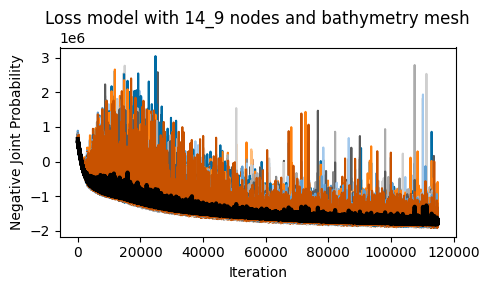

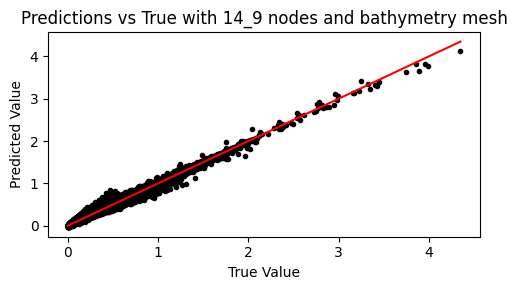

In [ ]:
%%time

n_nodes = NNodes.N14_9
mesh = TypeMesh.bathymetry

#for n_nodes in NNodes:
#    for mesh in TypeMesh:
    
print(f':: Training model with {n_nodes.value[0]} nodes and {mesh.value} mesh')
table = exp_dic[mesh][n_nodes][TypeScore.RMSE.value][TypeVariable.sst_temperature.value].to_dataframe().dropna().reset_index() 
table["lead_time"] = table["lead_time"].dt.total_seconds() / 86400  # to days

train, test = train_test_split(
    table,
    test_size=0.2,
    stratify=table["lead_time"],
    random_state=0
)

# Define Bayesian Neural Field
model = BayesianNeuralFieldVI(
    feature_cols=['lead_time', 'latitude', 'longitude'], # time, spatial 1, ..., spatial n
    target_col='sst_temperature',   
    timetype='float',
    standardize=['latitude', 'longitude'],
    depth=2,        # antes 2 o 3 → OK
    width=128,      # antes 512 → demasiado grande para 8GB
    fourier_degrees=[4,4,4],
    )
    
model.fit(
    train, 
    seed=jax.random.PRNGKey(0), 
    batch_size=512, 
    num_epochs=100,
    learning_rate=1e-3,
    kl_weight=0.5,
    )
table_template = table.drop(columns=['sst_temperature'])
yhat, yhat_quantiles = model.predict(table_template, quantiles=(0.025, 0.5, 0.975))

np.save(f"/home/giovanny/Seacast/data/atlantic/static/bayesnf_yhat_{n_nodes.value[0]}_{mesh.value}.npy", yhat)
means, stds = np.row_stack(yhat)[:, 0, :], np.row_stack(yhat)[:, 1, :]

fig, ax = plt.subplots(figsize=(5, 3), tight_layout=True)
plot_loss_model(model, ax=ax)
ax.set_title(f"Loss model with {n_nodes.value[0]} nodes and {mesh.value} mesh")

fig, ax = plt.subplots(figsize=(5,3), tight_layout=True)
plot_pred_true(table, yhat_quantiles, ax=ax)
ax.set_title(f"Predictions vs True with {n_nodes.value[0]} nodes and {mesh.value} mesh")

/tmp/ipykernel_2120612/1675944448.py:23: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  return np.row_stack(yhat)[:, 0, :][:, idx]


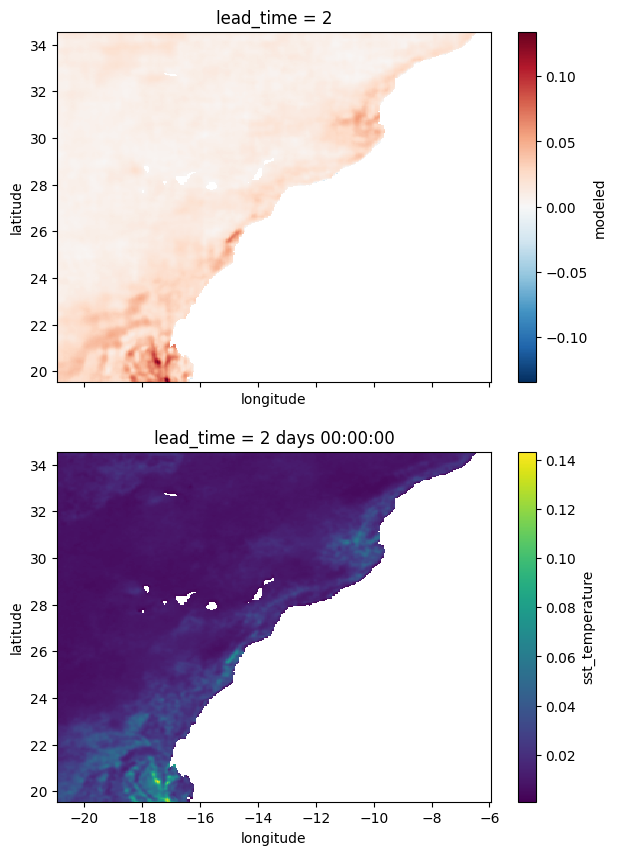

In [10]:
def to_xarray(table_template: pd.DataFrame, yhat: np.ndarray) -> xr.DataArray:

    df = pd.DataFrame()
    for leadtime in range(1, 16):
        ensamble = _sel_leadtime(table_template, yhat, leadtime=leadtime)
        lat, lon = _get_latlon_by_leadtime(table_template, leadtime=leadtime)
        df_leadtime = pd.DataFrame({
            "modeled": np.mean(ensamble, axis=0), 
            "latitude": lat,
            "longitude": lon,
            "lead_time": leadtime,
            })
        df = pd.concat(
            [df, df_leadtime], 
            ignore_index=True,
            )

    return df.set_index(["lead_time", "latitude", "longitude"]).to_xarray() 

def _sel_leadtime(table_template: pd.DataFrame, yhat: np.ndarray, leadtime: int) -> np.ndarray:
    idx = list(table_template[table_template["lead_time"] == leadtime].index)
    
    return np.row_stack(yhat)[:, 0, :][:, idx]

def _get_latlon_by_leadtime(table_template: pd.DataFrame, leadtime: int) -> tuple[np.ndarray, np.ndarray]:
    lat = table_template[table_template["lead_time"] == leadtime]["latitude"].values
    lon = table_template[table_template["lead_time"] == leadtime]["longitude"].values
    
    return lat, lon

n_nodes = NNodes.N14_9
mesh = TypeMesh.bathymetry
table = exp_dic[mesh][n_nodes][TypeScore.RMSE.value][TypeVariable.sst_temperature.value].to_dataframe().dropna().reset_index() 
table["lead_time"] = table["lead_time"].dt.total_seconds() / 86400  # to days

yhat = np.load(f'/home/giovanny/Seacast/data/atlantic/static/bayesnf_yhat_{n_nodes.value[0]}_{mesh.value}.npy')

# Comparisson between RMSE and modeled RMSE
lead_time = 1
fig,axs = plt.subplots(2,1, figsize=(7,10), sharex=True)
to_xarray(table, yhat)["modeled"].isel(lead_time=lead_time).plot(ax=axs[0])
exp_dic[mesh][n_nodes][TypeScore.RMSE.value][TypeVariable.sst_temperature.value].isel(lead_time=lead_time).plot(ax=axs[1])

/tmp/ipykernel_2203696/2531332164.py:16: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  self.means, self.stds = np.row_stack(self.yhat_data)[:, 0, :], np.row_stack(self.yhat_data)[:, 1, :]
/tmp/ipykernel_2203696/2531332164.py:16: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  self.means, self.stds = np.row_stack(self.yhat_data)[:, 0, :], np.row_stack(self.yhat_data)[:, 1, :]
/tmp/ipykernel_2203696/2531332164.py:16: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  self.means, self.stds = np.row_stack(self.yhat_data)[:, 0, :], np.row_stack(self.yhat_data)[:, 1, :]
/tmp/ipykernel_2203696/2531332164.py:16: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  self.means, self.stds = np.row_stack(self.yhat_data)[:, 0, :], np.row_stack(self.yhat_data)[:, 1, :]
/tmp/ipykernel_2203696/2531332164.py:16: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack

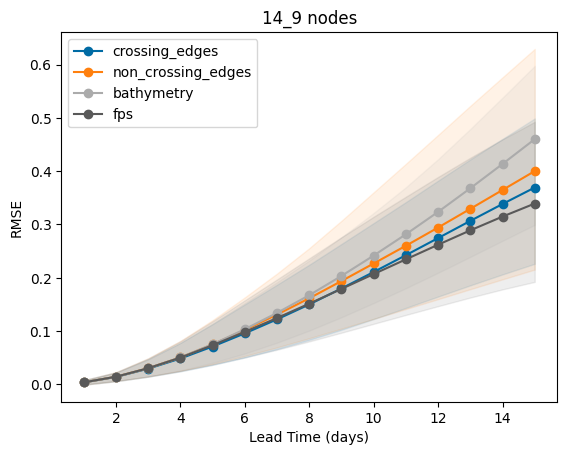

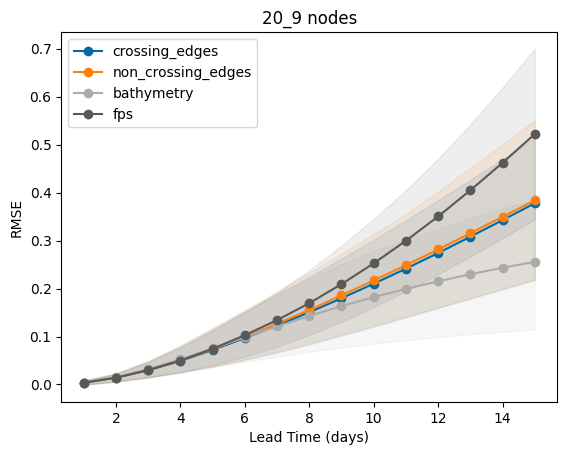

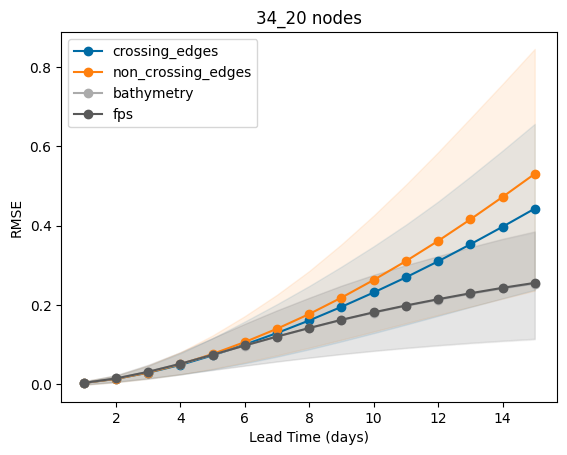

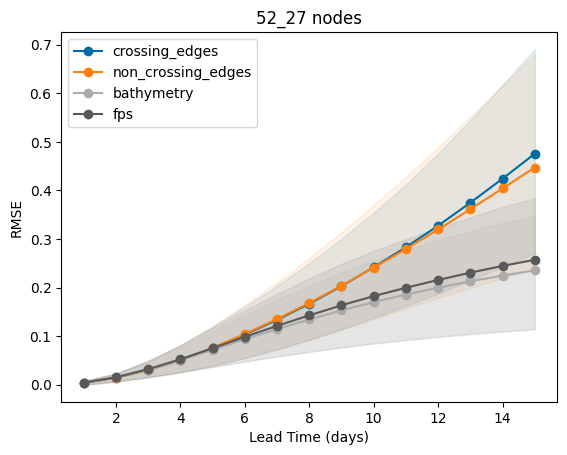

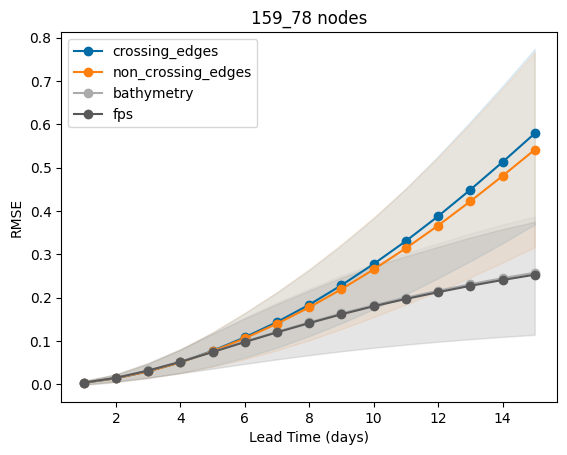

In [79]:
n_nodes = NNodes.N14_9
mesh = TypeMesh.bathymetry

from dataclasses import dataclass
from typing import Tuple, Dict

@dataclass
class AnalysisTuple:
    table_data: pd.DataFrame 
    yhat_data: np.ndarray

    def __post_init__(self):
        assert self.table_data.shape[0] == self.yhat_data.shape[-1], \
            "Table and yhat must have the same length"
        self.test_reset = self.table_data.reset_index(drop=True)
        self.means, self.stds = np.row_stack(self.yhat_data)[:, 0, :], np.row_stack(self.yhat_data)[:, 1, :]
    
def bias_correction(yhat: np.ndarray, y: pd.DataFrame) -> np.ndarray:
    assert yhat.ndim == 2, "yhat must be a 2D array"
    assert y.ndim == 1, "y must be a 1D array"
    assert yhat.shape[-1] == y.shape[0], "yhat and y must have the same length"
    bias = np.mean(yhat, axis=0) - y.values
    
    return yhat - bias
    
def get_statistics(
    analysis_tuple: AnalysisTuple, 
    quantiles: list = [0.025, 0.5, 0.975]
    ) -> Tuple[Dict[int, np.ndarray], Dict[int, np.ndarray]]:
    quantiles_map = {}
    mean_std_map = {}
    yhat_corrected_map = {}
    test_reset = analysis_tuple.test_reset
    means = analysis_tuple.means
    for n_time in range(1, 16):
        # Filter lead time
        df_by_lead_time = test_reset[test_reset["lead_time"] == n_time]
        idx = list(df_by_lead_time.index)
        means_by_lead_time = means[:, idx]
        yhat_corrected_by_lead_time = bias_correction(means_by_lead_time, df_by_lead_time['sst_temperature'])
        # get quantiles
        yhat_corrected_map[n_time] = yhat_corrected_by_lead_time
        quantiles_map[n_time] = np.quantile(yhat_corrected_by_lead_time, quantiles)
        mean_std_map[n_time] = np.mean(yhat_corrected_by_lead_time), np.std(yhat_corrected_by_lead_time)

    return mean_std_map, quantiles_map, yhat_corrected_map

for n_nodes in NNodes:
    fig,axs = plt.subplots()
    for mesh in TypeMesh:

        exp_arr = exp_dic[mesh][n_nodes][TypeScore.RMSE.value][TypeVariable.sst_temperature.value]
        table = exp_arr.to_dataframe().dropna().reset_index() 
        yhat = np.load(f'/home/giovanny/Seacast/data/atlantic/static/bayesnf_yhat_{n_nodes.value[0]}_{mesh.value}.npy')
        table["lead_time"] = table["lead_time"].dt.total_seconds() / 86400  # to days

        analysis_tuple = AnalysisTuple(table, yhat)
        confidence = 0.66
        plow = np.round((1-confidence)/2, 3)
        phigh = np.round(1-(1-confidence)/2, 3)
        mean_std_map, quantiles_map, _ = get_statistics(analysis_tuple, [plow, 0.5, phigh])
        quantiles = np.array(list(quantiles_map.values()))
        mean_hat = np.array(list(mean_std_map.values()))[:, 0]
        qlow, _, qhigh = quantiles[:, 0], quantiles[:, 1], quantiles[:, 2]
        lead_days = exp_arr.lead_time.data.astype('timedelta64[D]')
        line, = axs.plot(lead_days, mean_hat, marker='o', linestyle='-', label=f'{mesh.value}')
        line_color = line.get_color()
        axs.fill_between(lead_days.astype('float64'), qlow, qhigh, color=line_color, alpha=0.1)
    axs.set_xlabel("Lead Time (days)")
    axs.set_ylabel("RMSE")
    axs.set_title(f"{n_nodes.value[0]} nodes")
    axs.legend()
    plt.savefig(f"/home/giovanny/Seacast/reports/figures/exp_n_nodes_confidence_{n_nodes.value[0]}.pdf", bbox_inches='tight')

In [80]:
n_nodes = NNodes.N159_78
mesh = TypeMesh.bathymetry

exp_arr = exp_dic[mesh][n_nodes][TypeScore.RMSE.value][TypeVariable.sst_temperature.value]
table = exp_arr.to_dataframe().dropna().reset_index() 
yhat = np.load(f'/home/giovanny/Seacast/data/atlantic/static/bayesnf_yhat_{n_nodes.value[0]}_{mesh.value}.npy')
table["lead_time"] = table["lead_time"].dt.total_seconds() / 86400  # to days

analysis_tuple = AnalysisTuple(table, yhat)
confidence = 0.66
plow = np.round((1-confidence)/2, 3)
phigh = np.round(1-(1-confidence)/2, 3)
_, _, yhat_corrected_bmesh = get_statistics(analysis_tuple, [plow, 0.5, phigh])

/tmp/ipykernel_2203696/2531332164.py:16: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  self.means, self.stds = np.row_stack(self.yhat_data)[:, 0, :], np.row_stack(self.yhat_data)[:, 1, :]


In [81]:
n_nodes = NNodes.N159_78
mesh = TypeMesh.crossing_edges

exp_arr = exp_dic[mesh][n_nodes][TypeScore.RMSE.value][TypeVariable.sst_temperature.value]
table = exp_arr.to_dataframe().dropna().reset_index() 
yhat = np.load(f'/home/giovanny/Seacast/data/atlantic/static/bayesnf_yhat_{n_nodes.value[0]}_{mesh.value}.npy')
table["lead_time"] = table["lead_time"].dt.total_seconds() / 86400  # to days

analysis_tuple = AnalysisTuple(table, yhat)
confidence = 0.66
plow = np.round((1-confidence)/2, 3)
phigh = np.round(1-(1-confidence)/2, 3)
_, _, yhat_corrected_ucmesh = get_statistics(analysis_tuple, [plow, 0.5, phigh])

/tmp/ipykernel_2203696/2531332164.py:16: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  self.means, self.stds = np.row_stack(self.yhat_data)[:, 0, :], np.row_stack(self.yhat_data)[:, 1, :]


In [86]:
confidence = 0.66
plow = np.round((1-confidence)/2, 3)
phigh = np.round(1-(1-confidence)/2, 3)

for n_time, (yhat_bmesh, yhat_ucmesh )in enumerate(
    zip(yhat_corrected_bmesh.values(), yhat_corrected_ucmesh.values())
    ):
    q_low, q_high = np.quantile(yhat_bmesh - yhat_ucmesh, [plow, phigh])
    # Si ambos tienen el mismo signo, el cero quedó fuera.
    print(q_low, q_high)
    es_significativo = np.sign(q_low) == np.sign(q_high)
    print(f'{n_time} es_significativo: {es_significativo}')

-0.005492144608870149 0.005868264473974705
0 es_significativo: False
-0.004387945625931025 0.00655330286361277
1 es_significativo: False
-0.004216690994799137 0.007757493052631615
2 es_significativo: False
-0.006618879735469818 0.008224068898707627
3 es_significativo: False
-0.012787901554256678 0.006707594208419314
4 es_significativo: False
-0.024190532937645913 0.0025834645330905792
5 es_significativo: False
-0.04201570428907871 -0.004713967442512512
6 es_significativo: True
-0.06762948907911777 -0.01590327642858029
7 es_significativo: True
-0.10138792350888252 -0.0315664535015822
8 es_significativo: True
-0.14314868107438086 -0.05149276390671734
9 es_significativo: True
-0.19259978994727134 -0.07448128722608093
10 es_significativo: True
-0.2498241662979126 -0.0998936538398266
11 es_significativo: True
-0.3137504270672798 -0.12738221883773804
12 es_significativo: True
-0.38321188420057295 -0.15737373024225237
13 es_significativo: True
-0.4573676100373268 -0.1899205242097378
14 es_sig

In [85]:
confidence = 0.95
plow = np.round((1-confidence)/2, 3)
phigh = np.round(1-(1-confidence)/2, 3)

for n_time, (yhat_bmesh, yhat_ucmesh )in enumerate(
    zip(yhat_corrected_bmesh.values(), yhat_corrected_ucmesh.values())
    ):
    q_low, q_high = np.quantile(yhat_bmesh - yhat_ucmesh, [plow, phigh])
    # Si ambos tienen el mismo signo, el cero quedó fuera.
    print(q_low, q_high)
    es_significativo = np.sign(q_low) == np.sign(q_high)
    print(f'{n_time} es_significativo: {es_significativo}')

-0.01331730568781495 0.013433755398727954
0 es_significativo: False
-0.011494789831340313 0.014638958568684758
1 es_significativo: False
-0.012015180801972747 0.01995474975556137
2 es_significativo: False
-0.017120257578790186 0.02816508710384369
3 es_significativo: False
-0.029526740871369837 0.03833264186978341
4 es_significativo: False
-0.05055645126849413 0.04882587864995008
5 es_significativo: False
-0.08021678905934095 0.05868837758898743
6 es_significativo: False
-0.12055066637694835 0.06658808067440997
7 es_significativo: False
-0.17161436714231967 0.07350999489426618
8 es_significativo: False
-0.233618126809597 0.07845658324658875
9 es_significativo: False
-0.30544859543442726 0.08091080337762835
10 es_significativo: False
-0.3873838536441326 0.08087647221982483
11 es_significativo: False
-0.47759244218468666 0.07989341616630563
12 es_significativo: False
-0.5744668245315552 0.07813331037759819
13 es_significativo: False
-0.6781108394265175 0.07634568810463005
14 es_significat